# PINN ecuación de convección-difusión 1D

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## Ecuación a solucionar
$$ a\frac{du}{dx} - \nu \frac{d^2u}{dx^2}-1=0 $$

donde $a$ es una constante de velocidad y $\nu$ es un parametro de viscosidad.
La solución exacta para $x \in (0,1) $ es

$$ u(x) = x - \frac{e^{-R(1-x)}-e^{-R}}{1-e^{-R}}$$

donde $R = a/\nu$ y es el número de Reynolds. Esta solución es para las condiciones de frontera 
$$ u(0) = u(1) = 0$$

In [3]:
def exact_solution(a,nu,x):
    R = a/nu
    denominador = 1 - np.exp(-R)
    u = x - ( np.exp(-R*(1-x)) - np.exp(-R))/denominador
    return u

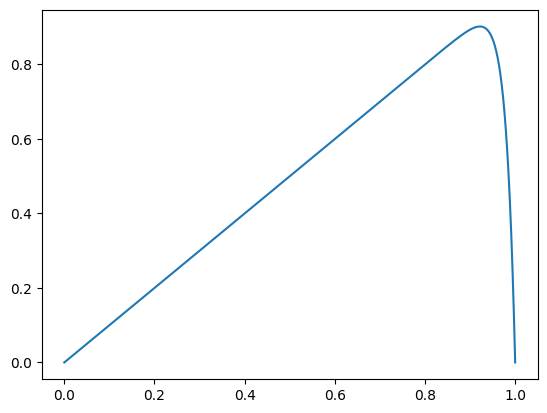

In [53]:
n = 1000 
x_test = torch.linspace(0,1,n).view(-1,1) 
a,v = 1.0,0.02
u_test = exact_solution(a,v,x_test)
plt.plot(x_test,u_test)



In [54]:
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[                    ## capas de input
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[                   ## capas densas
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)     ## capa de salida
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [ ]:
torch.manual_seed(115)   ## Se inicia la red.
pinn = FCN(1,1,42,3)
#pinn1 = FCN(1,1,42,3)
#pinn

In [84]:
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-3)       ## parametros
x_boundary = x_test[0:n:n-1].requires_grad_(True) ## Punto donde está la condición de frontera [No necesario en el code]
x_physics = torch.linspace(0,1,40).view(-1,1).requires_grad_(True)  ## Puntos de colocación

In [85]:
files_0 = []             ## Guardar los datos
loss1_history_0 = []
loss2_history_0 = []
loss3_history_0 = []
loss_history_0 = []
mse_history_0 = []

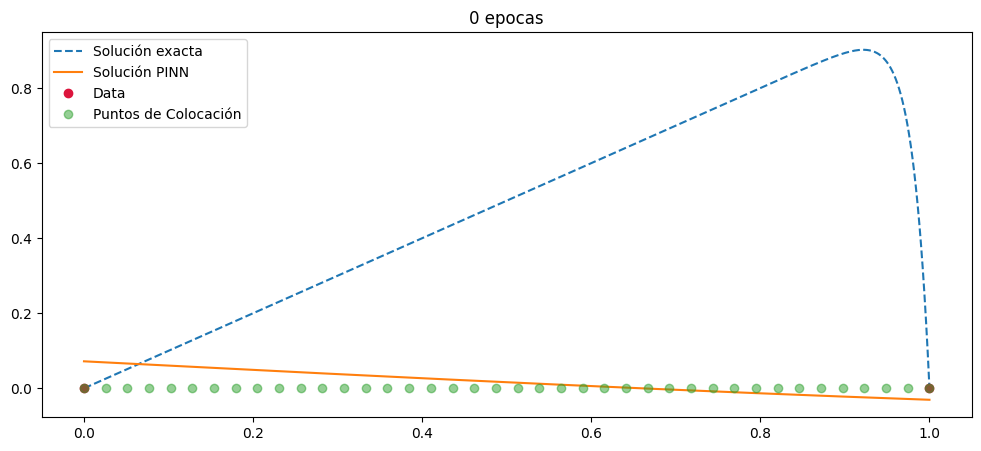

99
199
299
399
499
599
699
799
899
999
1099
1199
1299
1399
1499
1599
1699
1799
1899
1999
2099
2199
2299
2399
2499
2599
2699
2799
2899
2999
3099
3199
3299
3399
3499
3599
3699
3799
3899
3999
4099
4199
4299
4399
4499
4599
4699
4799
4899
4999


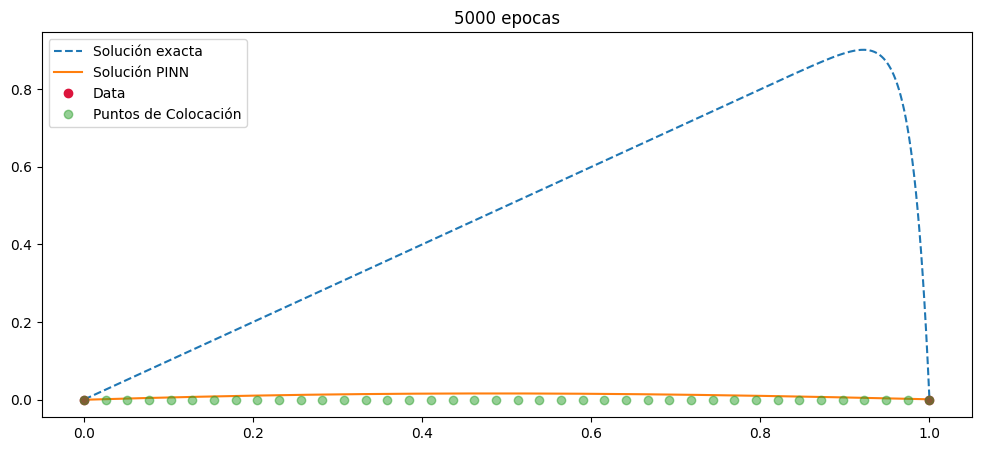

5099
5199
5299
5399
5499
5599
5699
5799
5899
5999
6099
6199
6299
6399
6499
6599
6699
6799
6899
6999
7099
7199
7299
7399
7499
7599
7699
7799
7899
7999
8099
8199
8299
8399
8499
8599
8699
8799
8899
8999
9099
9199
9299
9399
9499
9599
9699
9799
9899
9999


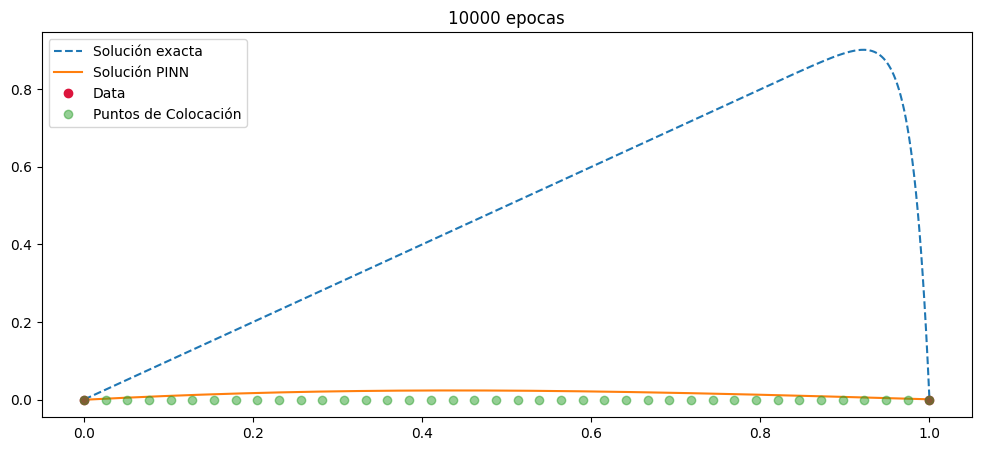

10099
10199
10299
10399
10499
10599
10699
10799
10899
10999
11099
11199
11299
11399
11499
11599
11699
11799
11899
11999
12099
12199
12299
12399
12499
12599
12699
12799
12899
12999
13099
13199
13299
13399
13499
13599
13699
13799
13899
13999
14099
14199
14299
14399
14499
14599
14699
14799
14899
14999


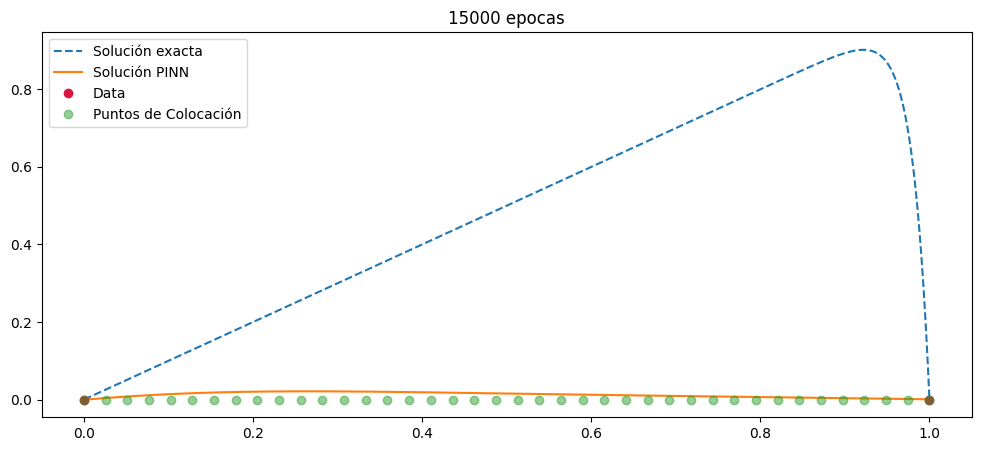

la mejor epoca de entrenamiento es 15031
la mejor epoca de entrenamiento es 15032
la mejor epoca de entrenamiento es 15033
la mejor epoca de entrenamiento es 15034
la mejor epoca de entrenamiento es 15035
la mejor epoca de entrenamiento es 15036
la mejor epoca de entrenamiento es 15037
la mejor epoca de entrenamiento es 15038
la mejor epoca de entrenamiento es 15039
la mejor epoca de entrenamiento es 15040
la mejor epoca de entrenamiento es 15041
la mejor epoca de entrenamiento es 15042
la mejor epoca de entrenamiento es 15043
la mejor epoca de entrenamiento es 15044
la mejor epoca de entrenamiento es 15045
la mejor epoca de entrenamiento es 15046
la mejor epoca de entrenamiento es 15047
la mejor epoca de entrenamiento es 15048
la mejor epoca de entrenamiento es 15049
la mejor epoca de entrenamiento es 15050
la mejor epoca de entrenamiento es 15051
la mejor epoca de entrenamiento es 15052
la mejor epoca de entrenamiento es 15053
la mejor epoca de entrenamiento es 15054
la mejor epoca d

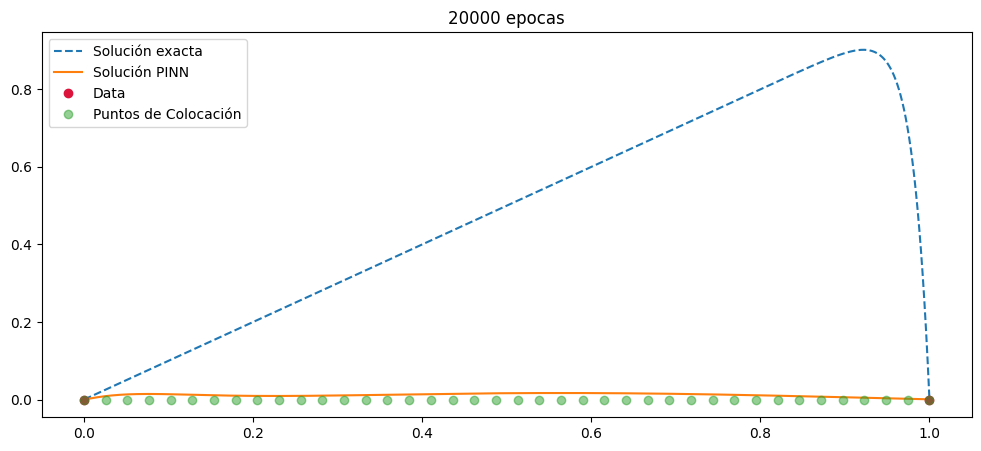

la mejor epoca de entrenamiento es 20001
la mejor epoca de entrenamiento es 20002
la mejor epoca de entrenamiento es 20003
la mejor epoca de entrenamiento es 20004
la mejor epoca de entrenamiento es 20005
la mejor epoca de entrenamiento es 20006
la mejor epoca de entrenamiento es 20007
la mejor epoca de entrenamiento es 20008
la mejor epoca de entrenamiento es 20009
la mejor epoca de entrenamiento es 20010
la mejor epoca de entrenamiento es 20011
la mejor epoca de entrenamiento es 20012
la mejor epoca de entrenamiento es 20013
la mejor epoca de entrenamiento es 20014
la mejor epoca de entrenamiento es 20015
la mejor epoca de entrenamiento es 20016
la mejor epoca de entrenamiento es 20017
la mejor epoca de entrenamiento es 20018
la mejor epoca de entrenamiento es 20019
la mejor epoca de entrenamiento es 20020
la mejor epoca de entrenamiento es 20021
la mejor epoca de entrenamiento es 20022
la mejor epoca de entrenamiento es 20023
la mejor epoca de entrenamiento es 20024
la mejor epoca d

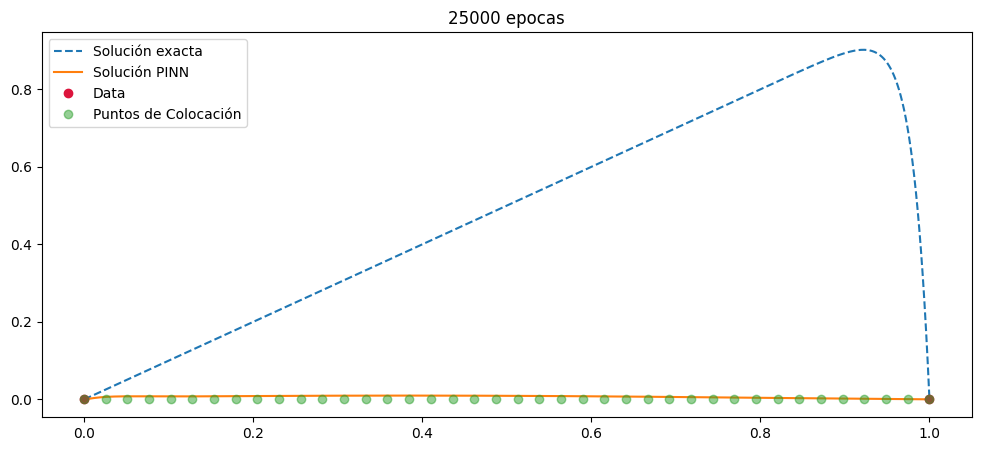

In [71]:
best_loss = float('inf')    ## Guarda los parametros de la mejor red
best_model_state = None


for i in range(25001):
    optimiser.zero_grad()

    u = pinn(x_boundary) ## Se calcula el punto u(0) con la PINN
    u0 = 0.0             ## Condición de frontera u(0) = u(1) = u0 

    loss1 = torch.mean((torch.squeeze(u) - u0)**2)  ## Función de perdida de las condiciones de frontera.

    #dudt = torch.autograd.grad(u,x_boundary,torch.ones_like(u),create_graph=True)[0]  ##  se calcula y'(0)
    #v0 = 0
    #loss2 = (torch.squeeze(dudt)-v0)**2    ## condición y'(0) = 0

    u = pinn(x_physics)              ## Se calcula y para los puntos de colocación
    dudt = torch.autograd.grad(u,x_physics,torch.ones_like(u),create_graph=True)[0]   ## se calcula dydt
    d2udt2 = torch.autograd.grad(dudt,x_physics,torch.ones_like(dudt),create_graph=True)[0] ## se calcula d2y/dt2
    loss3 = torch.mean( (-v*d2udt2 + a*dudt  -1 )**2 )  ## Función de perdida física

    lambda1 = 1.0; lambda2 = 9.e-2; lambda3 = 3.e-4  ## Pesos de las funciones de perdida

    loss = lambda1*loss1  + lambda3*loss3 #+ lambda2*loss2  ## Función de perdida total
    loss.backward()
    optimiser.step()
    
    if loss < best_loss:  
        best_loss = loss
        best_model_state = pinn.state_dict()  # Guardamos el estado del modelo
        filename = f'best_model_0.pth'
        # Guardamos los parámetros del modelo si la pérdida mejora
        torch.save(best_model_state, filename)
        if i >= 15000:
            print(f'la mejor epoca de entrenamiento es {i}')

    if (i+1) % 100 == 0: 
        loss1_history_0.append(loss1.detach())
        #loss2_history_0.append(loss2.detach())
        loss3_history_0.append(loss3.detach())
        loss_history_0.append(loss.detach())
        print(i)
    if i%5000 == 0:       ## Se plotea cada 
        u = pinn(x_test)
        u = u.detach()
        plt.figure(figsize=(12,5))
        plt.plot(x_test,u_test,'--',label='Solución exacta')
        #plt.plot(t_testing,u1,marker='o')
        plt.plot(x_test,u,label='Solución PINN')
        plt.plot(0,0,'o',label='Data',color='crimson')
        plt.plot(1,0,'o',color='crimson')
        tt = x_physics.detach()
        plt.plot(tt,np.zeros_like(tt),'o',label='Puntos de Colocación',alpha=0.5)
        plt.title(f'{i} epocas')
        plt.legend()
        plt.show()


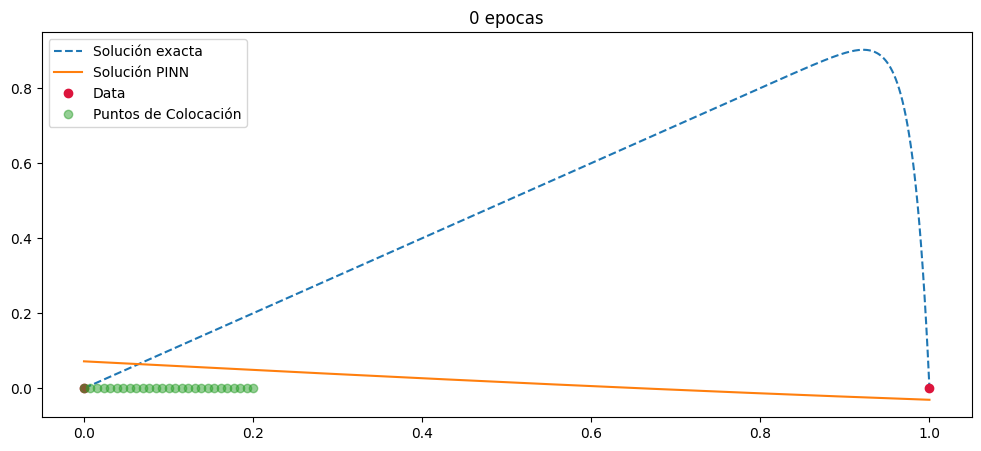

99
199
299
399
499
599
699
799
899
999
1099
1199
1299
1399
1499
1599
1699
1799
1899
1999
2099
2199
2299
2399
2499
2599
2699
2799
2899
2999
3099
3199
3299
3399
3499
3599
3699
3799
3899
3999
4099
4199
4299
4399
4499
4599
4699
4799
4899
4999


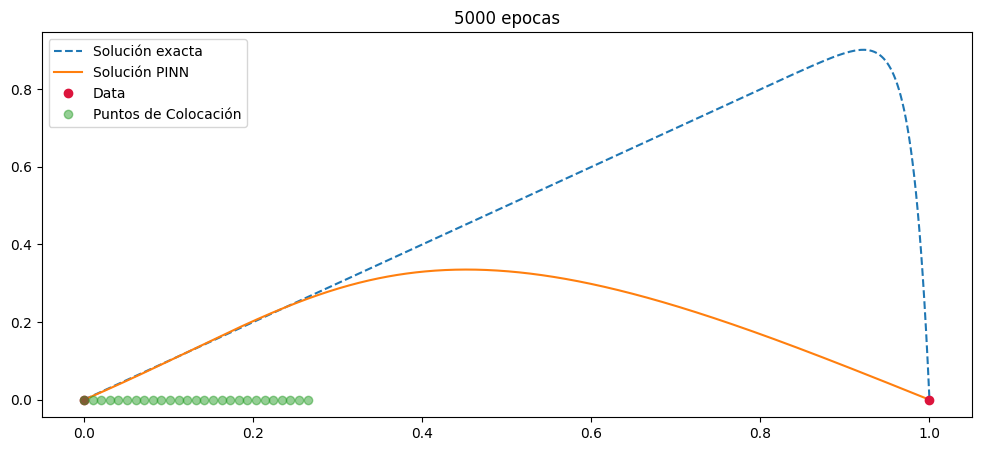

5099
5199
5299
5399
5499
5599
5699
5799
5899
5999
6099
6199
6299
6399
6499
6599
6699
6799
6899
6999
7099
7199
7299
7399
7499
7599
7699
7799
7899
7999
8099
8199
8299
8399
8499
8599
8699
8799
8899
8999
9099
9199
9299
9399
9499
9599
9699
9799
9899
9999


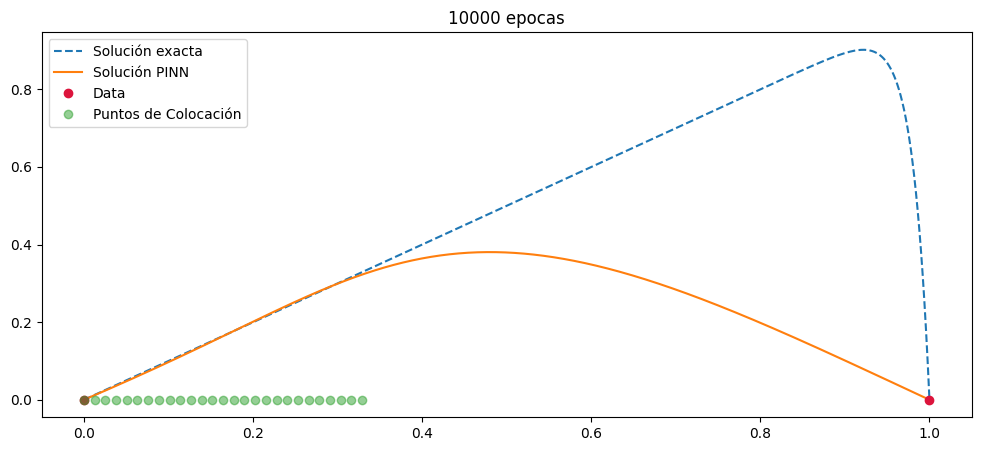

10099
10199
10299
10399
10499
10599
10699
10799
10899
10999
11099
11199
11299
11399
11499
11599
11699
11799
11899
11999
12099
12199
12299
12399
12499
12599
12699
12799
12899
12999
13099
13199
13299
13399
13499
13599
13699
13799
13899
13999
14099
14199
14299
14399
14499
14599
14699
14799
14899
14999


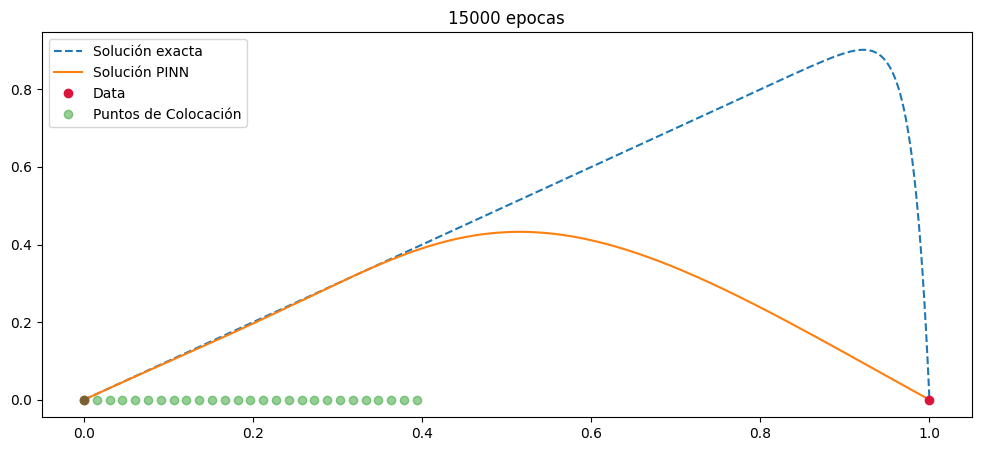

15099
15199
15299
15399
15499
15599
15699
15799
15899
15999
16099
16199
16299
16399
16499
16599
16699
16799
16899
16999
17099
17199
17299
17399
17499
17599
17699
17799
17899
17999
18099
18199
18299
18399
18499
18599
18699
18799
18899
18999
19099
19199
19299
19399
19499
19599
19699
19799
19899
19999


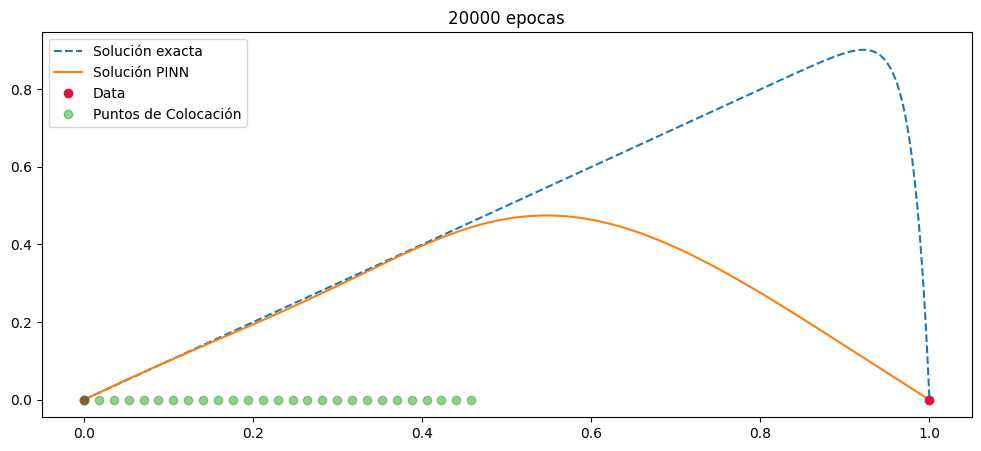

20099
20199
20299
20399
20499
20599
20699
20799
20899
20999
21099
21199
21299
21399
21499
21599
21699
21799
21899
21999
22099
22199
22299
22399
22499
22599
22699
22799
22899
22999
23099
23199
23299
23399
23499
23599
23699
23799
23899
23999
24099
24199
24299
24399
24499
24599
24699
24799
24899
24999


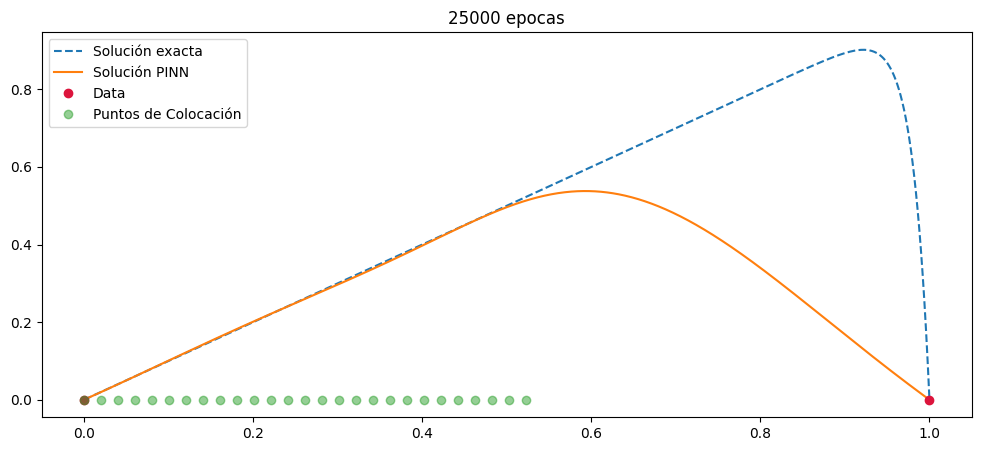

25099
25199
25299
25399
25499
25599
25699
25799
25899
25999
26099
26199
26299
26399
26499
26599
26699
26799
26899
26999
27099
27199
27299
27399
27499
27599
27699
27799
27899
27999
28099
28199
28299
28399
28499
28599
28699
28799
28899
28999
29099
29199
29299
29399
29499
29599
29699
la mejor epoca de entrenamiento es 29763
la mejor epoca de entrenamiento es 29764
la mejor epoca de entrenamiento es 29765
la mejor epoca de entrenamiento es 29766
la mejor epoca de entrenamiento es 29767
la mejor epoca de entrenamiento es 29768
la mejor epoca de entrenamiento es 29769
la mejor epoca de entrenamiento es 29770
la mejor epoca de entrenamiento es 29771
la mejor epoca de entrenamiento es 29772
la mejor epoca de entrenamiento es 29773
la mejor epoca de entrenamiento es 29774
la mejor epoca de entrenamiento es 29775
la mejor epoca de entrenamiento es 29776
la mejor epoca de entrenamiento es 29777
la mejor epoca de entrenamiento es 29778
la mejor epoca de entrenamiento es 29779
la mejor epoca de ent

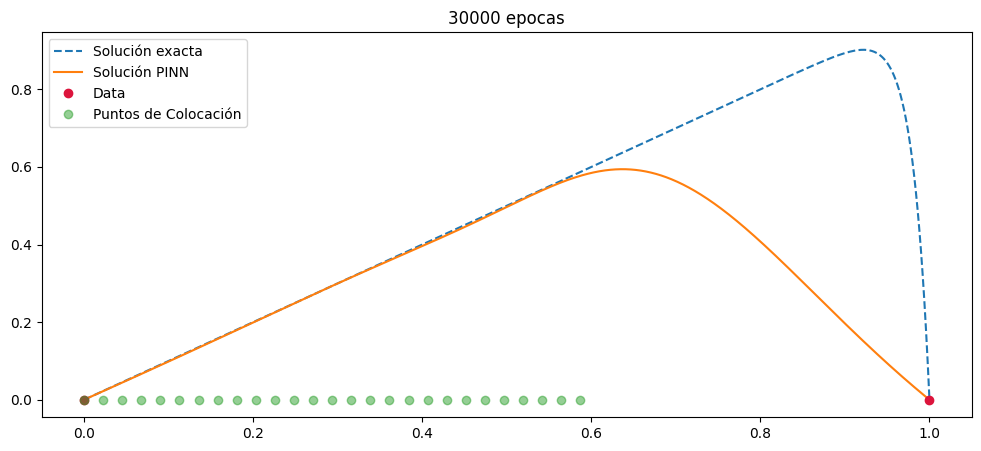

la mejor epoca de entrenamiento es 30043
la mejor epoca de entrenamiento es 30044
la mejor epoca de entrenamiento es 30045
la mejor epoca de entrenamiento es 30046
la mejor epoca de entrenamiento es 30047
la mejor epoca de entrenamiento es 30048
la mejor epoca de entrenamiento es 30049
la mejor epoca de entrenamiento es 30050
la mejor epoca de entrenamiento es 30051
la mejor epoca de entrenamiento es 30052
la mejor epoca de entrenamiento es 30053
la mejor epoca de entrenamiento es 30054
la mejor epoca de entrenamiento es 30055
la mejor epoca de entrenamiento es 30056
la mejor epoca de entrenamiento es 30057
la mejor epoca de entrenamiento es 30058
la mejor epoca de entrenamiento es 30059
la mejor epoca de entrenamiento es 30060
la mejor epoca de entrenamiento es 30061
la mejor epoca de entrenamiento es 30062
la mejor epoca de entrenamiento es 30063
30099
30199
la mejor epoca de entrenamiento es 30263
la mejor epoca de entrenamiento es 30264
la mejor epoca de entrenamiento es 30265
la m

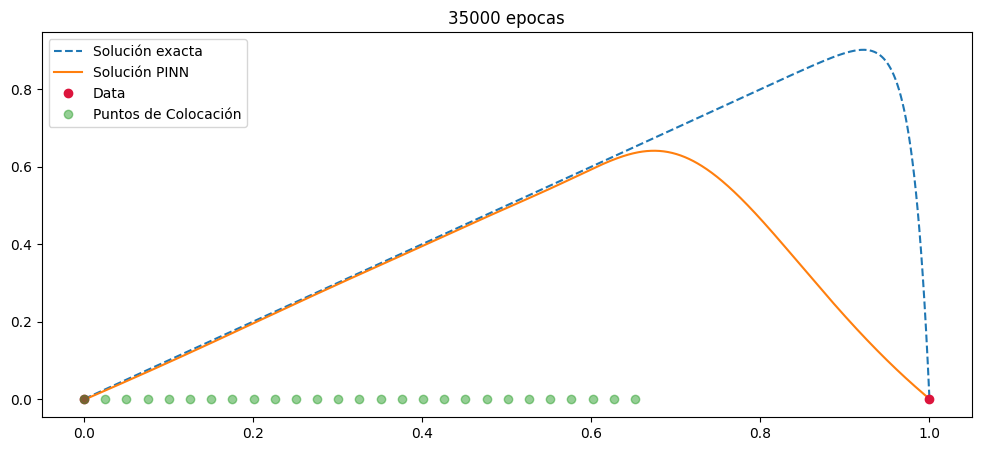

35099
35199
35299
35399
35499
35599
35699
35799
35899
35999
36099
36199
36299
la mejor epoca de entrenamiento es 36395
la mejor epoca de entrenamiento es 36396
la mejor epoca de entrenamiento es 36397
la mejor epoca de entrenamiento es 36398
la mejor epoca de entrenamiento es 36399
36399
la mejor epoca de entrenamiento es 36400
la mejor epoca de entrenamiento es 36401
36499
36599
la mejor epoca de entrenamiento es 36622
la mejor epoca de entrenamiento es 36623
la mejor epoca de entrenamiento es 36624
la mejor epoca de entrenamiento es 36625
36699
36799
36899
36999
37099
37199
37299
37399
37499
37599
37699
37799
37899
37999
38099
38199
38299
38399
38499
38599
38699
38799
38899
38999
la mejor epoca de entrenamiento es 39016
la mejor epoca de entrenamiento es 39017
la mejor epoca de entrenamiento es 39018
la mejor epoca de entrenamiento es 39019
la mejor epoca de entrenamiento es 39020
la mejor epoca de entrenamiento es 39021
la mejor epoca de entrenamiento es 39022
la mejor epoca de entr

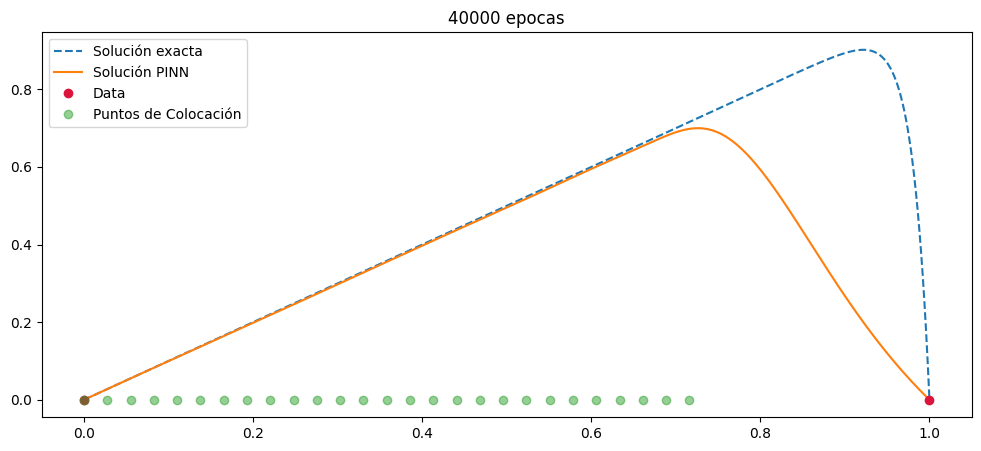

la mejor epoca de entrenamiento es 40035
la mejor epoca de entrenamiento es 40036
la mejor epoca de entrenamiento es 40037
la mejor epoca de entrenamiento es 40038
la mejor epoca de entrenamiento es 40039
la mejor epoca de entrenamiento es 40040
la mejor epoca de entrenamiento es 40041
la mejor epoca de entrenamiento es 40042
la mejor epoca de entrenamiento es 40043
la mejor epoca de entrenamiento es 40044
la mejor epoca de entrenamiento es 40045
40099
40199
la mejor epoca de entrenamiento es 40222
la mejor epoca de entrenamiento es 40223
la mejor epoca de entrenamiento es 40224
la mejor epoca de entrenamiento es 40225
la mejor epoca de entrenamiento es 40226
la mejor epoca de entrenamiento es 40227
la mejor epoca de entrenamiento es 40228
la mejor epoca de entrenamiento es 40229
la mejor epoca de entrenamiento es 40230
la mejor epoca de entrenamiento es 40231
la mejor epoca de entrenamiento es 40232
la mejor epoca de entrenamiento es 40233
la mejor epoca de entrenamiento es 40234
la m

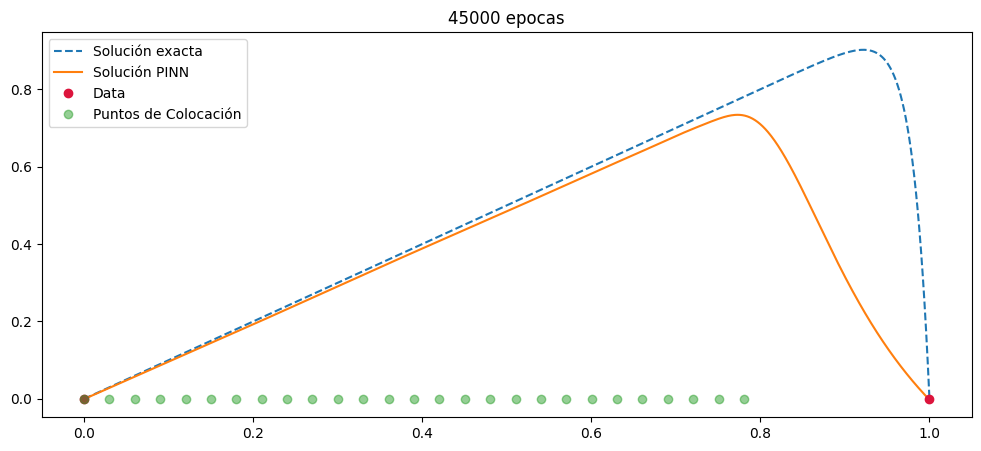

45099
la mejor epoca de entrenamiento es 45134
la mejor epoca de entrenamiento es 45135
la mejor epoca de entrenamiento es 45136
la mejor epoca de entrenamiento es 45137
45199
la mejor epoca de entrenamiento es 45298
la mejor epoca de entrenamiento es 45299
45299
la mejor epoca de entrenamiento es 45300
la mejor epoca de entrenamiento es 45301
la mejor epoca de entrenamiento es 45302
la mejor epoca de entrenamiento es 45303
la mejor epoca de entrenamiento es 45304
la mejor epoca de entrenamiento es 45305
la mejor epoca de entrenamiento es 45306
la mejor epoca de entrenamiento es 45307
la mejor epoca de entrenamiento es 45308
la mejor epoca de entrenamiento es 45309
la mejor epoca de entrenamiento es 45310
la mejor epoca de entrenamiento es 45311
la mejor epoca de entrenamiento es 45312
la mejor epoca de entrenamiento es 45313
la mejor epoca de entrenamiento es 45314
la mejor epoca de entrenamiento es 45315
la mejor epoca de entrenamiento es 45316
45399
la mejor epoca de entrenamiento e

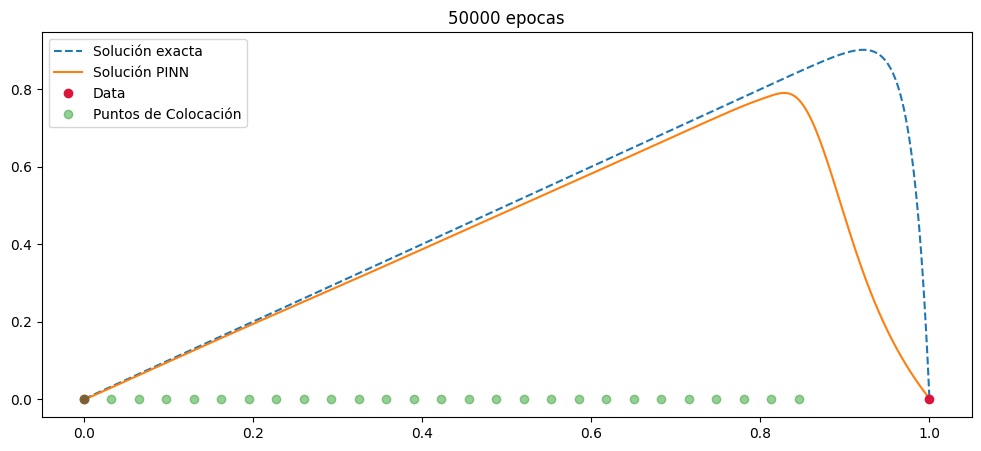

50099
50199
50299
50399
50499
50599
50699
50799
50899
50999
51099
51199
51299
51399
51499
51599
51699
51799
51899
51999
52099
52199
52299
52399
52499
52599
52699
52799
52899
52999
53099
53199
53299
53399
53499
53599
53699
53799
53899
53999
54099
54199
54299
54399
54499
54599
54699
54799
54899
54999


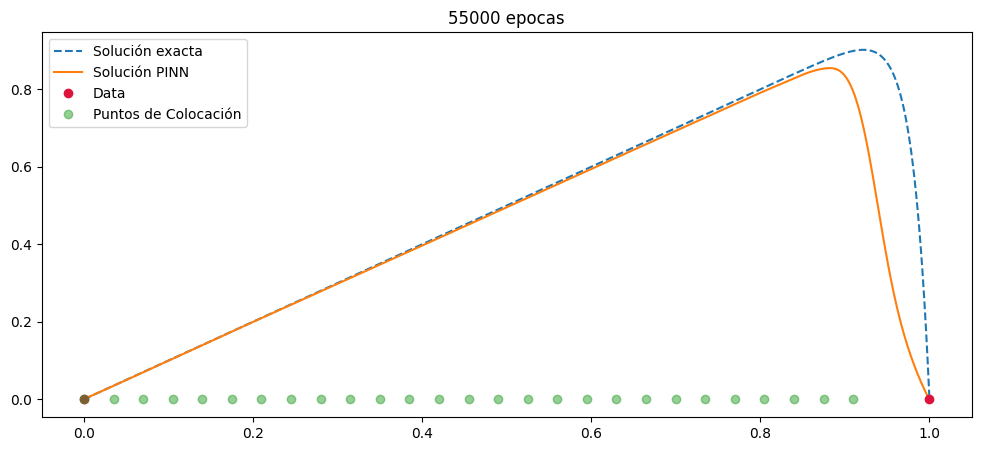

55099
55199
55299
55399
55499
55599
55699
55799
55899
55999
56099
56199
la mejor epoca de entrenamiento es 56253
la mejor epoca de entrenamiento es 56254
la mejor epoca de entrenamiento es 56255
la mejor epoca de entrenamiento es 56256
la mejor epoca de entrenamiento es 56257
la mejor epoca de entrenamiento es 56258
la mejor epoca de entrenamiento es 56259
la mejor epoca de entrenamiento es 56260
56299
56399
56499
56599
56699
56799
la mejor epoca de entrenamiento es 56881
la mejor epoca de entrenamiento es 56882
56899
56999
57099
la mejor epoca de entrenamiento es 57108
la mejor epoca de entrenamiento es 57109
la mejor epoca de entrenamiento es 57120
la mejor epoca de entrenamiento es 57121
la mejor epoca de entrenamiento es 57122
57199
57299
57399
57499
la mejor epoca de entrenamiento es 57583
57599
57699
57799
57899
57999
58099
58199
58299
58399
58499
58599
58699
58799
58899
58999
59099
59199
59299
59399
59499
59599
59699
59799
59899
59999


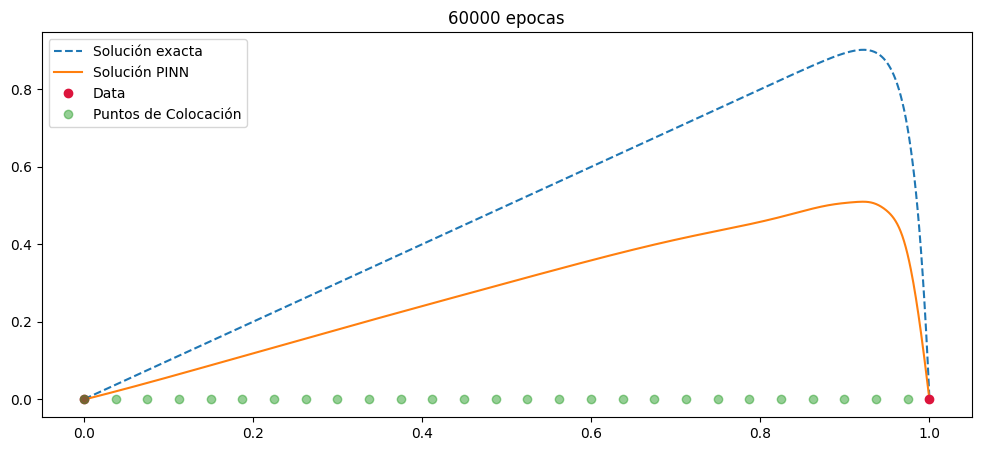

60099
60199
60299
60399
60499
60599
60699
60799
60899
60999
61099
61199
61299
61399
61499
61599
61699
61799
61899
61999
62099
62199
62299
62399
62499
62599
62699
62799
62899
62999
63099
63199
63299
63399
63499
63599
63699
63799
63899
63999
64099
64199
64299
64399
64499
64599
64699
64799
64899
64999


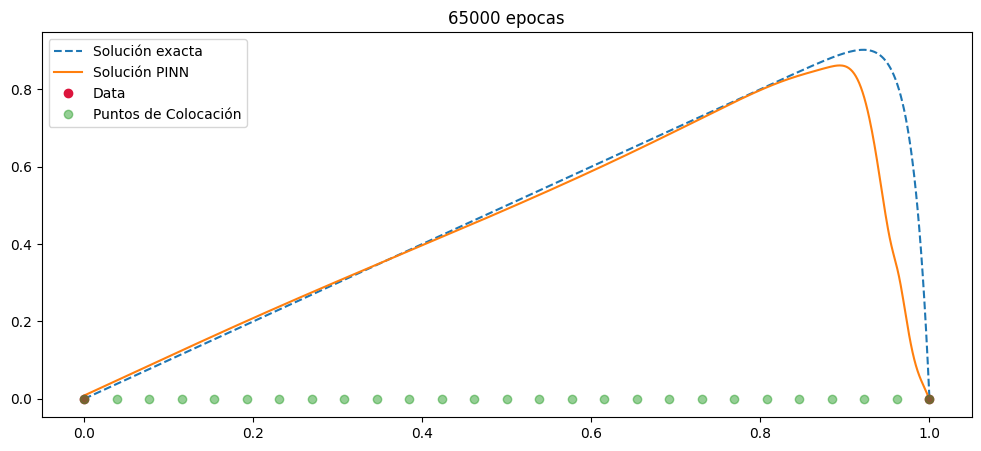

65099
65199
65299
65399
65499
65599
65699
65799
65899
65999
66099
66199
66299
66399
66499
66599
66699
66799
66899
66999
67099
67199
67299
67399
67499
67599
67699
67799
67899
67999
68099
68199
68299
68399
68499
68599
68699
68799
68899
68999
69099
69199
69299
69399
69499
69599
69699
69799
69899
69999


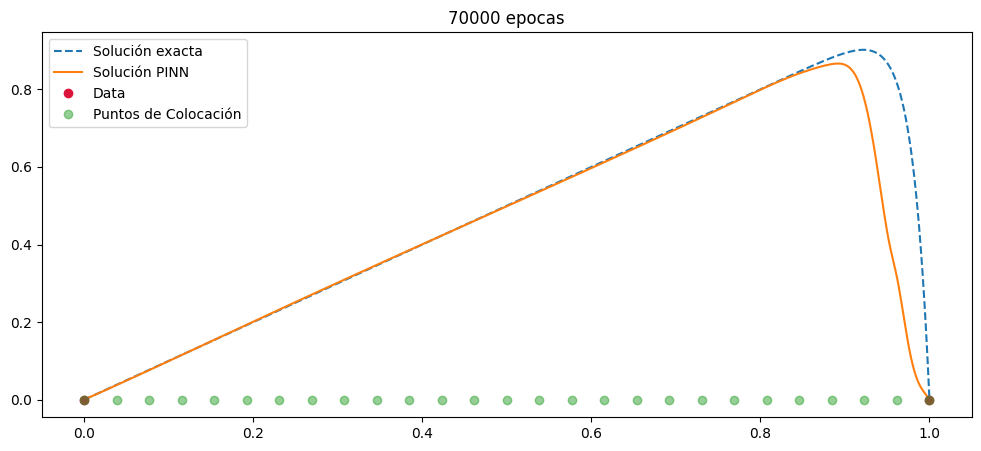

70099
70199
70299
70399
70499
70599
70699
70799
70899
70999
71099
71199
71299
71399
71499
71599
71699
71799
71899
71999
72099
72199
72299
72399
72499
72599
72699
72799
72899
72999
73099
73199
73299
73399
73499
73599
73699
73799
73899
73999
74099
74199
74299
74399
74499
74599
74699
74799
74899
74999


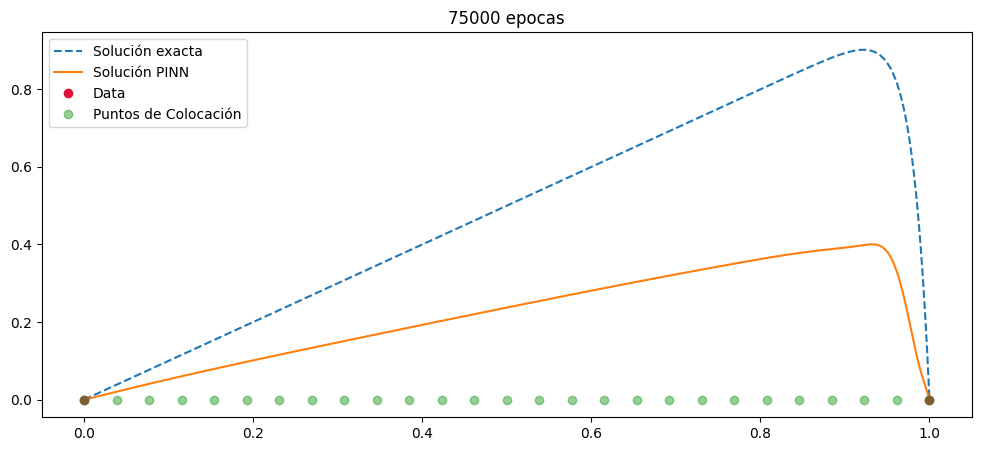

75099
75199
75299
75399
75499
75599
75699
75799
75899
75999
76099
76199
76299
76399
76499
76599
76699
76799
76899
76999
77099
77199
77299
77399
77499
77599
77699
77799
77899
77999
78099
78199
78299
78399
78499
78599
78699
78799
78899
78999
79099
79199
79299
79399
79499
79599
79699
79799
79899
79999


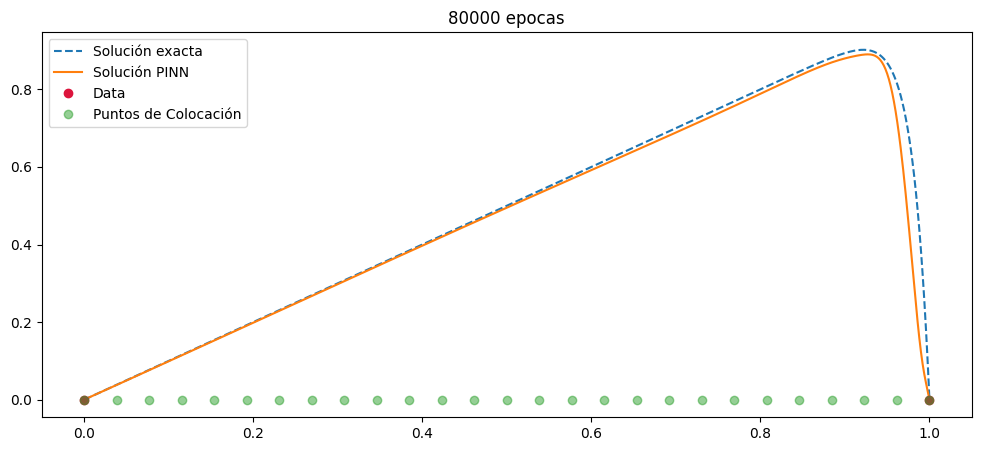

80099
80199
80299
80399
80499
80599
80699
80799
80899
80999


In [86]:
best_loss = float('inf')    ## Guarda los parametros de la mejor red
best_model_state = None


for i in range(81001):
    optimiser.zero_grad()
    lim=0.2 + np.minimum(0.8*i/62000,0.8)
    x_physics = torch.linspace(0.,lim,27).view(-1,1).requires_grad_(True)

    u = pinn(x_boundary) ## Se calcula el punto u(0) con la PINN
    u0 = 0.0             ## Condición de frontera u(0) = u(1) = u0 

    loss1 = torch.mean((torch.squeeze(u) - u0)**2)  ## Función de perdida de las condiciones de frontera.

    #dudt = torch.autograd.grad(u,x_boundary,torch.ones_like(u),create_graph=True)[0]  ##  se calcula y'(0)
    #v0 = 0
    #loss2 = (torch.squeeze(dudt)-v0)**2    ## condición y'(0) = 0

    u = pinn(x_physics)              ## Se calcula y para los puntos de colocación
    dudt = torch.autograd.grad(u,x_physics,torch.ones_like(u),create_graph=True)[0]   ## se calcula dydt
    d2udt2 = torch.autograd.grad(dudt,x_physics,torch.ones_like(dudt),create_graph=True)[0] ## se calcula d2y/dt2
    loss3 = torch.mean( (-v*d2udt2 + a*dudt  -1 )**2 )  ## Función de perdida física

    lambda1 = 1.0; lambda2 = 5.e-1; lambda3 = 3.e-4  ## Pesos de las funciones de perdida

    loss = lambda1*loss1  + lambda3*loss3 #+ lambda2*loss2  ## Función de perdida total
    loss.backward()
    optimiser.step()
    
    if loss < best_loss:  
        best_loss = loss
        best_model_state = pinn.state_dict()  # Guardamos el estado del modelo
        filename = f'best_model_0.pth'
        # Guardamos los parámetros del modelo si la pérdida mejora
        torch.save(best_model_state, filename)
        if i >= 15000:
            print(f'la mejor epoca de entrenamiento es {i}')

    if (i+1) % 100 == 0: 
        loss1_history_0.append(loss1.detach())
        #loss2_history_0.append(loss2.detach())
        loss3_history_0.append(loss3.detach())
        loss_history_0.append(loss.detach())
        print(i)
    if i%5000 == 0:       ## Se plotea cada 
        u = pinn(x_test)
        u = u.detach()
        plt.figure(figsize=(12,5))
        plt.plot(x_test,u_test,'--',label='Solución exacta')
        #plt.plot(t_testing,u1,marker='o')
        plt.plot(x_test,u,label='Solución PINN')
        plt.plot(0,0,'o',label='Data',color='crimson')
        plt.plot(1,0,'o',color='crimson')
        tt = x_physics.detach()
        plt.plot(tt,np.zeros_like(tt),'o',label='Puntos de Colocación',alpha=0.5)
        plt.title(f'{i} epocas')
        plt.legend()
        plt.show()


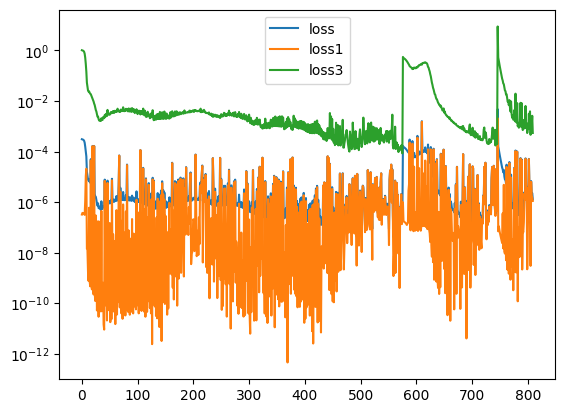

In [87]:
plt.plot(loss_history_0, label="loss")    ## Plots loss functions
plt.yscale('log')
plt.legend()

plt.plot(loss1_history_0, label="loss1")
plt.yscale('log')
plt.legend()


plt.plot(loss3_history_0, label="loss3")
plt.yscale('log')
plt.legend()

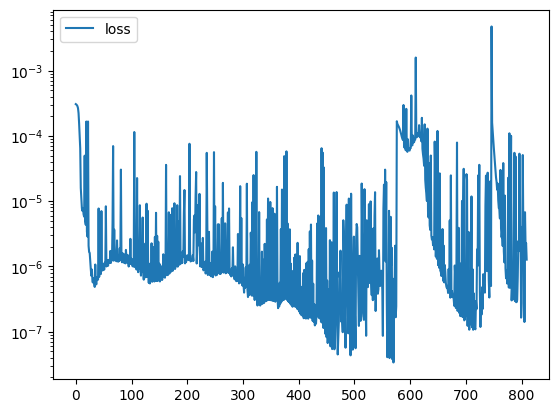

In [90]:
plt.plot(loss_history_0, label="loss")    ## Plots loss functions
plt.yscale('log')
plt.legend()


In [88]:
pinn_0 = FCN(1,1,42,3)
pinn_0.load_state_dict(torch.load('best_model_0.pth'))

C:\Users\ASUS PC\AppData\Local\Temp\ipykernel_12868\3002587962.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pinn_0.load_state_dict(torch.load('best_model_0.pth'))


<All keys matched successfully>

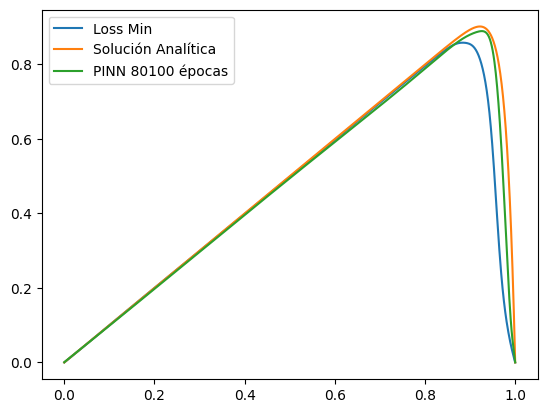

In [95]:
y0 = pinn_0(x_test)
y0 = y0.detach()
u = pinn(x_test)
u = u.detach()

plt.plot(x_test,y0,label='Loss Min')
plt.plot(x_test,u_test,label='Solución Analítica')
plt.plot(x_test,u,label='PINN 80100 épocas')
plt.legend()

